The code in this notebook relates to section 4.5.3 of the thesis: combining (40-by-40=pixel bounding box) localisation and segmentation.

For a given image, the trained localisation model from step 1  is applied to predict the 40x40 pixel bounding box containing the aneurysm.

The 40x40 bounding boxes are created from the predicted masks output by step 1 in an intermediate step.

The trained step 2 segmentation model is applied to the 40x40 bounding boxes.




# Installations

In [ ]:
pip -q install wandb

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 133 kB 41.1 MB/s 
     |████████████████████████████████| 97 kB 4.9 MB/s 
     |████████████████████████████████| 170 kB 46.9 MB/s 
     |████████████████████████████████| 63 kB 999 kB/s 


In [ ]:
pip -q install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations as A

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras import layers

import wandb
from wandb.keras import WandbCallback

from tqdm.auto import tqdm

os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

Running on TPU  ['10.32.180.98:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.32.180.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.32.180.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

# Functions for loading TFRecords files

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([256 * 256], tf.float32),
        "mask_raw": tf.io.FixedLenFeature([256 * 256], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)


def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [256, 256, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [256, 256])

    return image, mask


In [ ]:
### Data Augmentation

def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [256, 256, 1])

    mask = example_proto["mask_raw"]
    mask = tf.reshape(mask, [256, 256])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)
      mask = tf.image.rot90(tf.expand_dims(mask, [2]))
      mask = tf.squeeze(mask)

    return image, mask

In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  # ds = normalise(ds)
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size)
  ds = optimise_dataset(ds)
  return ds

def to_3_channels(image, mask):
  img_shape = (256, 256)
  image = tf.reshape(tf.repeat(image, 3), (*img_shape, 3))
  # mask = tf.reshape(tf.repeat(mask, 3), (*img_shape, 3)) 
  return image, mask

# Load data

87 test images in 40_bounding_box_step1and2/test_non_empty

In [ ]:
test_nonempty_gcs_pattern = "gs://40_bounding_box_step1and2/test_non_empty*"
test_nonempty_filenames = tf.io.gfile.glob(test_nonempty_gcs_pattern)

test_nonempty_ds = tf.data.TFRecordDataset(test_nonempty_filenames)
test_nonempty_ds = test_nonempty_ds.map(_parse_image_function)
test_nonempty_ds = test_nonempty_ds.map(_unpack_proto_aug)
test_nonempty_ds = test_nonempty_ds.map(to_3_channels)

test_ds = prepare_data(test_nonempty_ds)

In [ ]:
def display_img_mask(batch_num, img_num):

  for images, masks in test_ds.take(batch_num):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_masks = masks.numpy()

  plt.subplot(1,2,1)
  plt.imshow(numpy_images[img_num], cmap='gray')
  plt.title('Img')

  plt.subplot(1,2,2)
  plt.imshow(numpy_masks[img_num].reshape((256,256)), cmap='gray')
  plt.title('Mask')

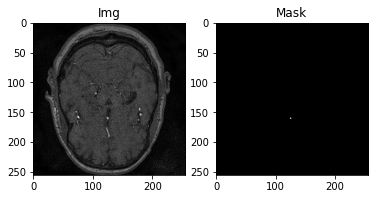

In [ ]:
display_img_mask(1,15)

# Loss Function

In [ ]:
# return our metric and loss

with tpu_strategy.scope():

  def dice_coef(y_true, y_pred, smooth=1e-15):
    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)

    return (2* intersection + smooth)/(K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


  def dice_coef_loss(y_true, y_pred):

    return (1.0 - dice_coef(y_true, y_pred))


  def mixed_loss(y_true, y_pred):

    y_true_f = tf.cast(K.flatten(y_true), tf.float32)
    y_pred_f = K.flatten(y_pred)

    bce = tf.keras.losses.binary_crossentropy(y_true_f, y_pred_f, from_logits=False)
    dice = dice_coef(y_true, y_pred)

    return bce + (1.0 - dice)

# Model Architecture

In [ ]:
# model parameters

with tpu_strategy.scope():

  loss = dice_coef_loss
  # loss = tf.keras.losses.binary_crossentropy
  # loss = mixed_loss
  metrics = dice_coef
  # metrics = ['binary_accuracy']

# Pre-trained Model: Original

In [ ]:
def rescale_output(y_pred):

  y_pred = tf.clip_by_value(y_pred, clip_value_min=0., clip_value_max=1.) # force values to be between 0 and 1

  return y_pred

In [ ]:
with tpu_strategy.scope(): 

  def unet_model(output_channels):

    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False) # ImageNet weights only work with 3 channel images

    # # adding regularization
    # penalty = 0.001
    # regularizer = tf.keras.regularizers.l2(penalty)

    # for layer in base_model.layers:
    #     for attr in ['kernel_regularizer']:
    #         if hasattr(layer, attr):
    #           setattr(layer, attr, regularizer)

    #  # When we change the layers attributes, the change only happens in the model config file
    # model_json = base_model.to_json()

    # # Save the weights before reloading the model.
    # weights_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/test5.h5"
    # # weights_path = os.path.join(weights_path, 'test1.h5')
    # base_model.save_weights(weights_path)

    # # load the model from the config
    # base_model = tf.keras.models.model_from_json(model_json)
    
    # # Reload the model weights
    # base_model.load_weights(weights_path, by_name=True)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 48x48
        'block_3_expand_relu',   # 24x24
        'block_6_expand_relu',   # 12x12
        'block_13_expand_relu',  # 6x6
        'block_16_project',      # 3x3
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(512, 3),  # 4x4 -> 8x8
        pix2pix.upsample(256, 3),  # 8x8 -> 16x16
        pix2pix.upsample(128, 3),  # 16x16 -> 32x32
        pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]


    skips = down_stack(inputs)
    x = skips[-1] # final output of encoder
    skips = reversed(skips[:-1]) # all outputs of encoder except final, reversed
    # Upsampling and establishing the skip connections
    
    for up, skip in zip(up_stack, skips):
      x = up(x) # pass output of encoder through decoder (iterates through outputs of decoder)
      concat = tf.keras.layers.Concatenate() 
      x = concat([x, skip]) # cross-link: output of decoder concatenated with encoder output
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    normalise_output = tf.keras.layers.Lambda(rescale_output)

    x = last(x)
    x = normalise_output(x)
    # x = tf.keras.activations.sigmoid(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Load trained Step 1 model

In [ ]:
model = keras.models.load_model("/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/Step1 40x40 bounding box/lr=1e-3_l2(0.001).h5", custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

# Evaluate on Test Set

In [ ]:
test_images = []
test_masks = []

for batch_num in [2]:
  for images, masks in test_ds.take(batch_num):  
        numpy_images = images.numpy()
        numpy_masks = masks.numpy()

        test_images.append(numpy_images)
        test_masks.append(numpy_masks)

numpy_images = np.concatenate(test_images)
numpy_masks = np.concatenate(test_masks)

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(tf.expand_dims(image, axis=[0])) for image in numpy_images]
test_preds = np.concatenate(test_preds) 

Predicting masks on test data...


In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list = []
dice_coeff_dict = {}

for i in range(len(numpy_masks)):
  true_mask = numpy_masks[i]
  pred_mask = test_preds[i].reshape((256,256))
  pred_mask = np.round(pred_mask)

  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list.append(dice_coeff)
  dice_coeff_dict[i] = dice_coeff

np.mean(dice_coeff_list), np.std(dice_coeff_list)

(0.00459719, 0.004716298)

Text(0, 0.5, 'Number of Images')

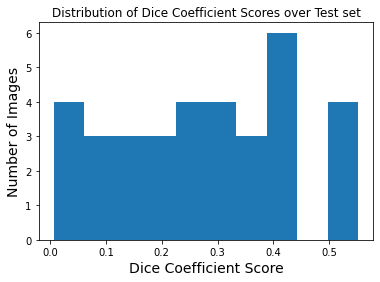

In [ ]:
plt.hist(dice_coeff_list)
plt.title('Distribution of Dice Coefficient Scores over Test set')
plt.xlabel('Dice Coefficient Score', size=14)
plt.ylabel('Number of Images', size=14)

In [ ]:
def compare_img_mask(img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.figure(figsize=(20, 4)) 

  plt.subplot(1,3,1)
  plt.imshow(numpy_images[img_num])
  plt.title('Original image patch')

  plt.subplot(1,3,2)
  plt.imshow(numpy_masks[img_num].reshape((256,256)), cmap='gray')
  plt.title('True mask')

  plt.subplot(1,3,3)
  plt.imshow(test_preds[img_num].reshape((256,256)), cmap='gray')
  plt.title('Predicted mask')

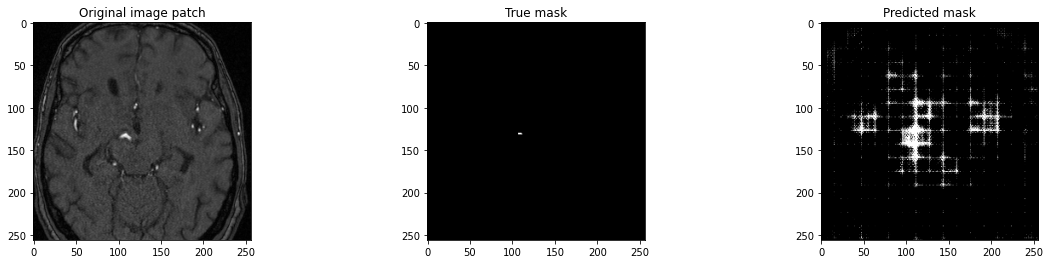

In [ ]:
compare_img_mask(25)

# Convert predictions to 40x40 bounding boxes

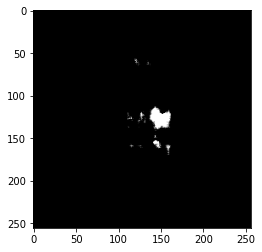

In [ ]:
test_test = test_preds[20].reshape((256,256))
plt.imshow(test_test, cmap='gray')

### testing connected components / filtering methods

https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html

In [ ]:
from skimage import measure
from skimage import filters
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n = 2
l = 80
threshold = 15.0

im = filters.gaussian(test_test, sigma= l / (4. * n))
blobs = im > threshold * im.mean()
blobs_labels = measure.label(blobs, background=0)

while(np.max(blobs_labels) == 0):
  print('False')
  threshold -= 1
  blobs = im > threshold * im.mean()
  blobs_labels = measure.label(blobs, background=0)

print(np.max(blobs_labels))

plt.imshow(blobs_labels, cmap='gray')
plt.title('Gaussian filter with \n threshold parameter = {}'.format(threshold))

NameError: ignored

In [ ]:
pixel_value_dict = {}

for i in range((np.min(blobs_labels)+1), (np.max(blobs_labels)+1)):
  pixel_value_dict[i] = np.count_nonzero(blobs_labels == i)

max_value = max(pixel_value_dict.values())

biggest_blob = [key for key, val in pixel_value_dict.items() if val == max_value][0]
biggest_blob

In [ ]:
a = rescale_intensity(test_test) # image
b = (blobs_labels==biggest_blob) # mask
plt.imshow(mark_boundaries(a,b, mode='thick')) # display image with mask overlaid
plt.title('Predicted mask with \n result of Gaussian filter \n (threshold parameter = 20) overlaid ')

In [ ]:
x_coords = np.where(blobs_labels == biggest_blob)[0]
y_coords = np.where(blobs_labels == biggest_blob)[1]

plt.imshow(test_test[np.min(x_coords):np.max(x_coords), np.min(y_coords):np.max(y_coords)], cmap='gray')

In [ ]:
test_test2 = test_test.copy()

x_diff = np.max(x_coords) - np.min(x_coords)
x_centre = np.min(x_coords) + x_diff//2

y_diff = np.max(y_coords) - np.min(y_coords)
y_centre = np.min(y_coords) + y_diff//2

test_test2[x_centre, y_centre] = 3

plt.figure(figsize=(12, 6))

plt.imshow(test_test2, cmap='gray')
plt.title('Predicted mask with centre of predicted \n aneurysm area marked by white pixel', size=16)

In [ ]:
# define bounding box around central pixel

x_left = x_centre-20
x_right = x_left + 40

y_top = y_centre-20
y_bottom = y_top + 40

plt.figure(figsize=(12, 6))

plt.imshow(test_test2[x_left:x_right, y_top:y_bottom],cmap='gray')
plt.title('40x40 bounding box centred at \n centre of predicted aneurysm area', size=18)

In [ ]:
def get_blobs_labels(test_pred):

  n = 2
  l = 80
  threshold = 15.0

  im = filters.gaussian(test_pred, sigma= l / (4. * n))
  blobs = im > threshold * im.mean()
  blobs_labels = measure.label(blobs, background=0)

  while(np.max(blobs_labels) == 0):
    print('False')
    threshold -= 1
    blobs = im > threshold * im.mean()
    blobs_labels = measure.label(blobs, background=0)

  return blobs_labels

def get_biggest_blob(blobs_labels):

  pixel_value_dict = {}
  for i in range((np.min(blobs_labels)+1), (np.max(blobs_labels)+1)):
    pixel_value_dict[i] = np.count_nonzero(blobs_labels == i)

  max_value = max(pixel_value_dict.values())
  biggest_blob = [key for key, val in pixel_value_dict.items() if val == max_value][0]

  return biggest_blob

def get_bounding_box1(test_pred, blobs_labels, biggest_blob):

  x_coords = np.where(blobs_labels==biggest_blob)[0]
  y_coords = np.where(blobs_labels==biggest_blob)[1]

  x_diff = np.max(x_coords) - np.min(x_coords)
  x_centre = np.min(x_coords) + x_diff//2

  y_diff = np.max(y_coords) - np.min(y_coords)
  y_centre = np.min(y_coords) + y_diff//2

  x_left = x_centre-20
  y_top = y_centre-20

  return x_centre, y_centre, x_left, y_top

### Create and display predicted mask bounding boxes

In [ ]:
def get_random_xy(x_centre, y_centre):
    rand_x = np.random.randint(x_centre - 40, x_centre) # always shows at least 5 pixels of an aneurysm
    rand_y = np.random.randint(y_centre - 40, y_centre)

    return rand_x, rand_y

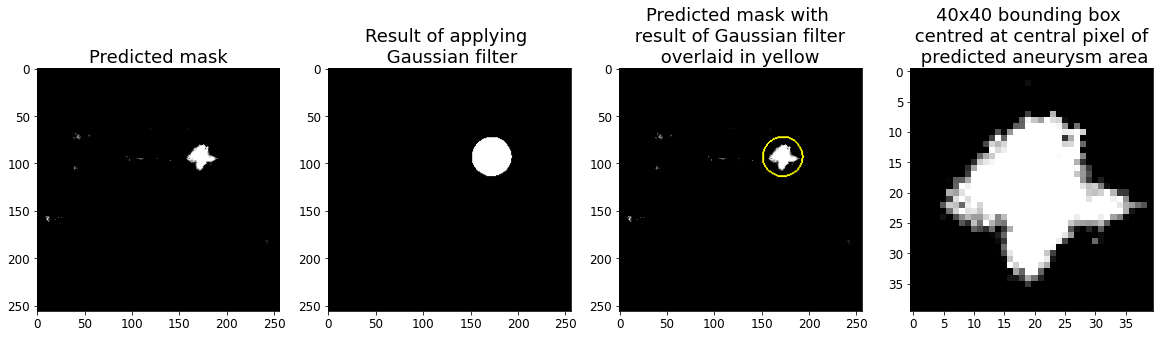

In [ ]:
# iterate through all predicted masks and create bounding boxes

# for i in range(test_preds.shape[0]):

i = 1

plt.figure(figsize=(20,10))

test_pred = test_preds[i].reshape((256,256))

plt.subplot(1,4,1)
plt.imshow(test_pred, cmap='gray')
plt.title('Predicted mask'.format(threshold), size=18)
plt.xticks(size=12)
plt.yticks(size=12)

blobs_labels = get_blobs_labels(test_pred)

plt.subplot(1,4,2)
plt.imshow(blobs_labels, cmap='gray')
plt.title('Result of applying \n Gaussian filter', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

biggest_blob = get_biggest_blob(blobs_labels)

a = rescale_intensity(test_pred) # image
b = (blobs_labels == biggest_blob) # mask
plt.subplot(1,4,3)
plt.imshow(mark_boundaries(a,b, mode='thick')) # display image with mask overlaid
plt.title('Predicted mask with \n result of Gaussian filter \n overlaid in yellow ', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

x_centre, y_centre, x_left, y_top = get_bounding_box1(test_pred, blobs_labels, biggest_blob)
bbox1 = test_pred[x_left:x_left+40, y_top:y_top+40]

plt.subplot(1,4,4)
plt.imshow(bbox1,cmap='gray')
plt.title('40x40 bounding box \n centred at central pixel of \n predicted aneurysm area', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

rand_x, rand_y = get_random_xy(x_centre, y_centre)
bbox2 = test_pred[rand_x:rand_x+40, rand_y:rand_y+40]

rand_x, rand_y = get_random_xy(x_centre, y_centre)
bbox3 = test_pred[rand_x:rand_x+40, rand_y:rand_y+40]

rand_x, rand_y = get_random_xy(x_centre, y_centre)
bbox4 = test_pred[rand_x:rand_x+40, rand_y:rand_y+40]

rand_x, rand_y = get_random_xy(x_centre, y_centre)
bbox5 = test_pred[rand_x:rand_x+40, rand_y:rand_y+40]

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text major ticklabel objects>)

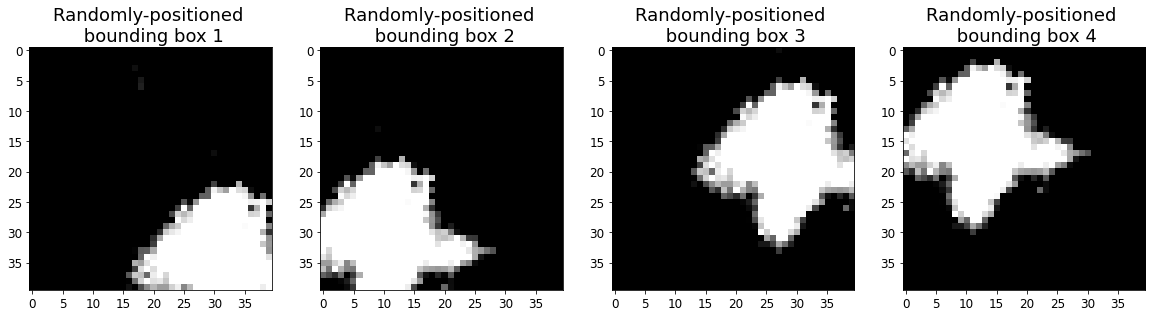

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(1,4,1)
plt.imshow(bbox2,cmap='gray')
plt.title('Randomly-positioned \n bounding box 1', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

plt.subplot(1,4,2)
plt.imshow(bbox3,cmap='gray')
plt.title('Randomly-positioned \n bounding box 2', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

plt.subplot(1,4,3)
plt.imshow(bbox4,cmap='gray')
plt.title('Randomly-positioned \n bounding box 3', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

plt.subplot(1,4,4)
plt.imshow(bbox5,cmap='gray')
plt.title('Randomly-positioned \n bounding box 4', size=18)
plt.xticks(size=12)
plt.yticks(size=12)

### Create bounding boxes for predicted masks, true masks and original images

In [ ]:
def crop_to_bbox1(img_array):
  return img_array[x_left:x_left+40, y_top:y_top+40]

def crop_to_bbox2(img_array):
  return img_array[rand_x:rand_x+40, rand_y:rand_y+40]
  
def crop_to_bbox3(img_array):
  return img_array[rand_x:rand_x+40, rand_y:rand_y+40]

def crop_to_bbox4(img_array):
  return img_array[rand_x:rand_x+40, rand_y:rand_y+40]

def crop_to_bbox5(img_array):
  return img_array[rand_x:rand_x+40, rand_y:rand_y+40]

In [ ]:
# iterate through all predicted masks and create bounding boxes

images_40x40 = []
true_masks_40x40 = []
pred_masks_40x40 = []

for i in range(test_preds.shape[0]):

  print(i)

  plt.figure(figsize=(10,10))

  test_pred = test_preds[i].reshape((256,256))
  test_image = numpy_images[i] # (256, 256, 3)
  test_mask = numpy_masks[i]

  blobs_labels = get_blobs_labels(test_pred)

  biggest_blob = get_biggest_blob(blobs_labels)

  a = rescale_intensity(test_pred) # image
  b = (blobs_labels == biggest_blob) # mask

  x_centre, y_centre, x_left, y_top = get_bounding_box1(test_pred, blobs_labels, biggest_blob)
  bbox1 = crop_to_bbox1(test_pred)
  pred_masks_40x40.append(bbox1)
  img_box1 = crop_to_bbox1(test_image)
  images_40x40.append(img_box1)
  mask_box1 = crop_to_bbox1(test_mask)
  true_masks_40x40.append(mask_box1)

  rand_x, rand_y = get_random_xy(x_centre, y_centre)
  bbox2 = crop_to_bbox2(test_pred)
  pred_masks_40x40.append(bbox2)
  img_box2 = crop_to_bbox2(test_image)
  images_40x40.append(img_box2)
  mask_box2 = crop_to_bbox2(test_mask)
  true_masks_40x40.append(mask_box2)

  rand_x, rand_y = get_random_xy(x_centre, y_centre)
  bbox3 = crop_to_bbox3(test_pred)
  pred_masks_40x40.append(bbox3)
  img_box3 = crop_to_bbox3(test_image)
  images_40x40.append(img_box3)
  mask_box3 = crop_to_bbox3(test_mask)
  true_masks_40x40.append(mask_box3)

  rand_x, rand_y = get_random_xy(x_centre, y_centre)
  bbox4 = crop_to_bbox4(test_pred)
  pred_masks_40x40.append(bbox4)
  img_box4 = crop_to_bbox4(test_image)
  images_40x40.append(img_box4)
  mask_box4 = crop_to_bbox4(test_mask)
  true_masks_40x40.append(mask_box4)

  rand_x, rand_y = get_random_xy(x_centre, y_centre)
  bbox5 = crop_to_bbox5(test_pred)
  pred_masks_40x40.append(bbox5)
  img_box5 = crop_to_bbox5(test_image)
  images_40x40.append(img_box5)
  mask_box5 = crop_to_bbox5(test_mask)
  true_masks_40x40.append(mask_box5)

  for j, img_box in enumerate([img_box1, img_box2, img_box3, img_box4, img_box5]):
    if img_box.shape != (40,40,3):
      print('Image number: {}, Box number: {}'.format(i,j))




0
1
2
False
False
False
False
False
3
4
5
6
7
8
9
10
False
False
False
False
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
False
False
33
34
35
36
37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


38
39
40
41
42
43
44
45
46
47
48
49
False
False
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
False
False
False
False
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text major ticklabel objects>)

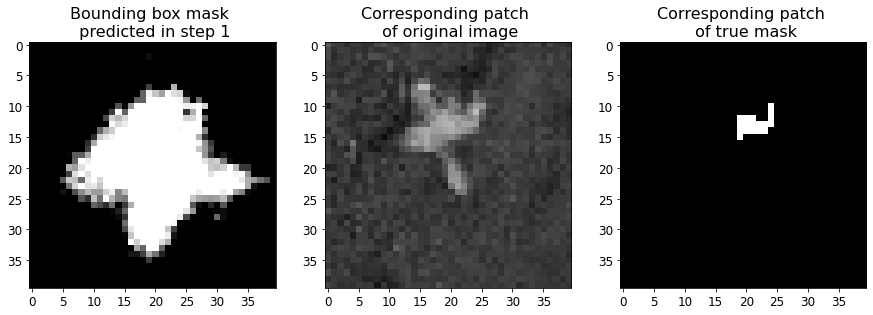

In [ ]:
img_num = 5

plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(pred_masks_40x40[img_num], cmap='gray')
plt.title('Bounding box mask \n predicted in step 1', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.subplot(1,3,2)
plt.imshow(images_40x40[img_num])
plt.title('Corresponding patch \n of original image', size=16)
plt.xticks(size=12)
plt.yticks(size=12)

plt.subplot(1,3,3)
plt.imshow(true_masks_40x40[img_num], cmap='gray')
plt.title('Corresponding patch \n of true mask', size=16)
plt.xticks(size=12)
plt.yticks(size=12)



# Step 2 Model

In [ ]:
model2 = keras.models.load_model("/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/Step2 40x40 bounding box/lr=1e-3_l2(0.01).h5", custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

In [ ]:
model2 = keras.models.load_model("/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/Step2 40x40 bounding box/v2/lr=1e-3_l2(0.01).h5", custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})

# Evaluate step2

In [ ]:
print('Predicting masks on test data...')

test_preds2 = [model2.predict(tf.expand_dims(image, axis=[0])) for image in images_40x40]
test_preds2 = np.concatenate(test_preds2)

Predicting masks on test data...


In [ ]:
def compare_img_mask(img_num):

  plt.figure(figsize=(15,10))

  plt.subplot(1,3,1)
  plt.imshow(images_40x40[img_num])
  plt.title('Image patch \n (input to step 2)', size=18)
  plt.xticks(size=12)
  plt.yticks(size=12)

  plt.subplot(1,3,2)
  plt.imshow(true_masks_40x40[img_num],CMAP='gray')
  plt.title('Corresponding patch \n of true mask', size=18)
  plt.xticks(size=12)
  plt.yticks(size=12)

  dice_score = np.round(float(dice_coeff_dict2[img_num]),3)

  plt.subplot(1,3,3)
  plt.imshow(np.round(test_preds2[img_num].reshape((40,40))), cmap='gray')
  plt.title('Predicted mask \n Dice score = {}'.format(dice_score), size=18)
  plt.xticks(size=12)
  plt.yticks(size=12)

## Evaluate all predictions

### Dice Score

In [ ]:
# calculate dice coeff for each pair of true (test_masks) and predicted (test_preds) masks in the test set

dice_coeff_list2 = []
dice_coeff_dict2 = {}

for i in range(len(true_masks_40x40)):
  true_mask = true_masks_40x40[i]
  pred_mask = test_preds2[i].reshape((40,40))
  pred_mask = np.round(pred_mask)

  dice_coeff = np.array(dice_coef(true_mask, pred_mask))
  dice_coeff_list2.append(dice_coeff)
  dice_coeff_dict2[i] = dice_coeff

np.mean(dice_coeff_list2), np.std(dice_coeff_list2)

(0.299438, 0.42508426)

(0.0, 350.0)

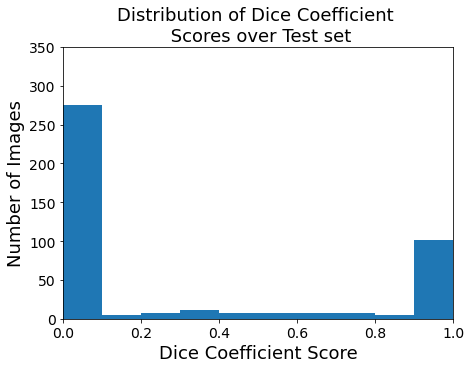

In [ ]:
plt.figure(figsize=(7,5))

plt.hist(dice_coeff_list2)
plt.title('Distribution of Dice Coefficient \n Scores over Test set', size=18)
plt.xlabel('Dice Coefficient Score', size=18)
plt.ylabel('Number of Images', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([0,1])
plt.ylim([0,350])

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
med = []
high = []

for key,val in dice_coeff_dict2.items():
  if val<0.1:
    low.append(key)
  elif val<0.5 and val>0.3:
    med.append(key)
  elif val>0.5:
    high.append(key)

len(low), len(med), len(high)

(275, 19, 126)

In [ ]:
# how many predicted masks that score highly are actually empty?

tot = 0

for i, pred_mask in enumerate(test_preds2):
  if np.any(test_preds2[i] != 0):
    if i in high:
      tot += 1

print('Empty: {}, Not empty: {}'.format(len(high) - tot, tot))

Empty: 65, Not empty: 61


In [ ]:
med

[9, 33, 144, 151, 241, 286, 305, 364, 408, 409, 417]

In [ ]:
high

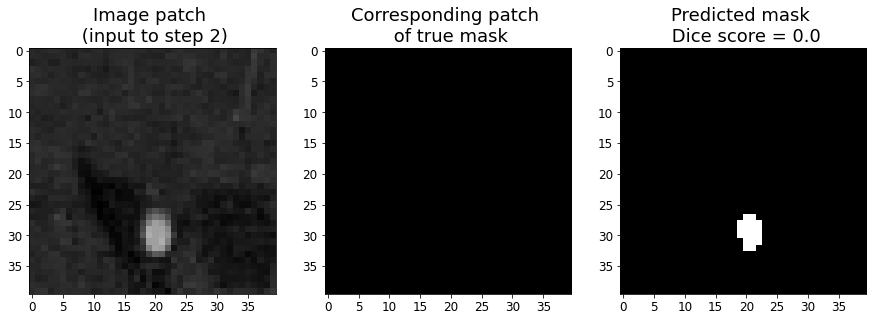

In [ ]:
compare_img_mask(406)

### Hausdorff Distance

In [ ]:
from scipy.spatial.distance import directed_hausdorff

In [ ]:
hausdorff_list2 = []
hausdorff_dict2 = {}

for i in range(len(true_masks_40x40)):
  true_mask = true_masks_40x40[i]
  pred_mask = test_preds2[i].reshape((40,40))
  pred_mask = np.round(pred_mask)

  hausdorff = directed_hausdorff(true_mask, pred_mask)[0]
  hausdorff_list2.append(hausdorff)
  hausdorff_dict2[i] = hausdorff

np.mean(hausdorff_list2), np.std(hausdorff_list2)

(0.5219744049507004, 0.7588271098513335)

(0.0, 350.0)

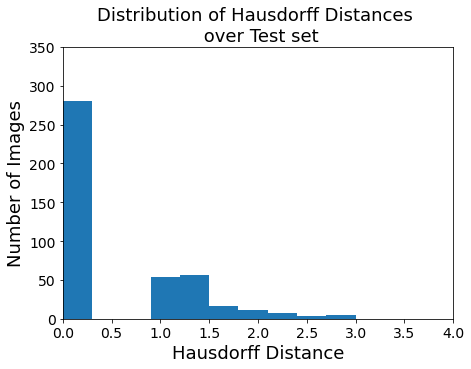

In [ ]:
plt.figure(figsize=(7,5))

plt.hist(hausdorff_list2)
plt.title('Distribution of Hausdorff Distances \n over Test set', size=18)
plt.xlabel('Hausdorff Distance', size=18)
plt.ylabel('Number of Images', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([0,4])
plt.ylim([0,350])

## Evaluate non-empty masks only

### Dice Score

In [ ]:
# calculate dice coeff only where true and predicted masks are non-empty

dice_coeff_list3 = []
dice_coeff_dict3 = {}
tot = 0

for i in range(len(true_masks_40x40)):
  true_mask = true_masks_40x40[i]
  pred_mask = test_preds2[i].reshape((40,40))
  pred_mask = np.round(pred_mask)

  if np.any(true_mask != 0) and np.any(pred_mask != 0):
    tot += 1
    dice_coeff = np.array(dice_coef(true_mask, pred_mask))
    dice_coeff_list3.append(dice_coeff)
    dice_coeff_dict3[i] = dice_coeff

np.mean(dice_coeff_list3), np.std(dice_coeff_list3)

(0.26818973, 0.30701062)

(0.0, 80.0)

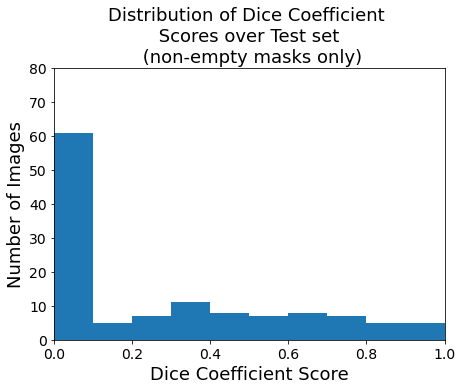

In [ ]:
plt.figure(figsize=(7,5))

plt.hist(dice_coeff_list3)
plt.title('Distribution of Dice Coefficient \n Scores over Test set \n (non-empty masks only)', size=18)
plt.xlabel('Dice Coefficient Score', size=18)
plt.ylabel('Number of Images', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([0,1])
plt.ylim([0,80])

In [ ]:
# create lists 'low' and 'high' that store indices of low and high scoring masks respectively

low = []
med = []
high = []

for key,val in dice_coeff_dict3.items():
  if val<0.1:
    low.append(key)
  elif val<0.5 and val>0.3:
    med.append(key)
  elif val>0.5:
    high.append(key)

len(low), len(med), len(high)

(52, 11, 32)

In [ ]:
med

[9, 33, 144, 151, 241, 286, 305, 364, 408, 409, 417]

In [ ]:
high

[12,
 97,
 122,
 143,
 145,
 146,
 148,
 149,
 240,
 242,
 244,
 265,
 266,
 267,
 268,
 269,
 289,
 345,
 346,
 347,
 348,
 352,
 365,
 366,
 367,
 369,
 380,
 381,
 382,
 383,
 406,
 415]

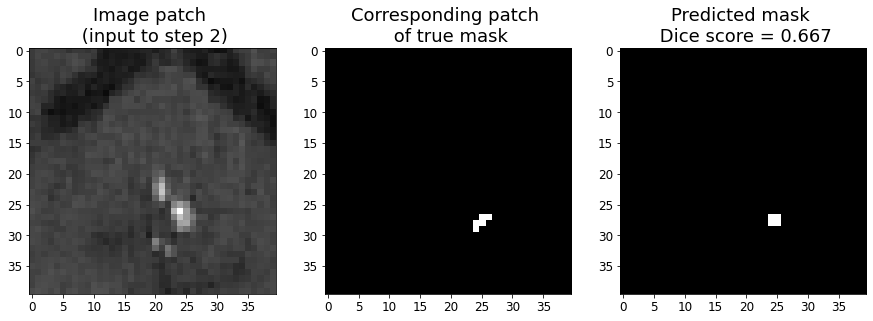

In [ ]:
compare_img_mask(143)

### Hausdorff Distance

In [ ]:
hausdorff_list3 = []
hausdorff_dict3 = {}
tot = 0

for i in range(len(true_masks_40x40)):
  true_mask = true_masks_40x40[i]
  pred_mask = test_preds2[i].reshape((40,40))
  pred_mask = np.round(pred_mask)

  if np.any(true_mask != 0) and np.any(pred_mask != 0):
    tot += 1
    hausdorff = directed_hausdorff(true_mask, pred_mask)[0]
    hausdorff_list3.append(hausdorff)
    hausdorff_dict3[i] = hausdorff

np.mean(hausdorff_list3), np.std(hausdorff_list3)

(1.2960301295688819, 0.5505129643698882)

(0.0, 60.0)

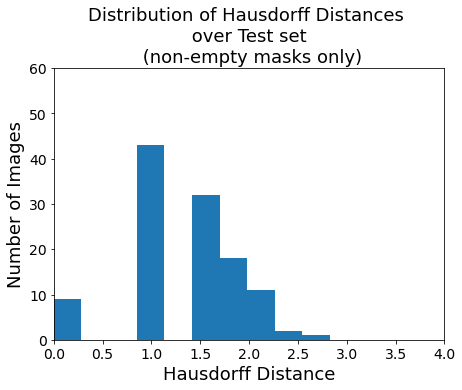

In [ ]:
plt.figure(figsize=(7,5))

plt.hist(hausdorff_list3)
plt.title('Distribution of Hausdorff Distances \n over Test set \n (non-empty masks only)', size=18)
plt.xlabel('Hausdorff Distance', size=18)
plt.ylabel('Number of Images', size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim([0,4])
plt.ylim([0,60])